In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML # used to display the specified object in the output area of the interactive environment.

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest # for determining outliers


from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.base import clone # for justifying KNN importance

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from sklearn.neighbors import NearestNeighbors

In [2]:
#let's read a csv (comma separated values) file (headers, each row is a data point)
bank_data = pd.read_csv('bank-additional-full.csv', delimiter=';', quotechar='"')

In [3]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

# Display the DataFrame and additional information
display(bank_data.head(), bank_data.shape, pd.DataFrame({'Data Types': bank_data.dtypes, 'Missing Values': bank_data.isna().any()}))

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


(41188, 21)

,Data Types,Missing Values
age,int64,False
job,object,False
marital,object,False
education,object,False
default,object,False
housing,object,False
loan,object,False
contact,object,False
month,object,False
day_of_week,object,False


In [4]:
numerical_features = bank_data.select_dtypes(exclude=['object'])
categorical_features = bank_data.select_dtypes(include=['object']).drop(columns=['y'])

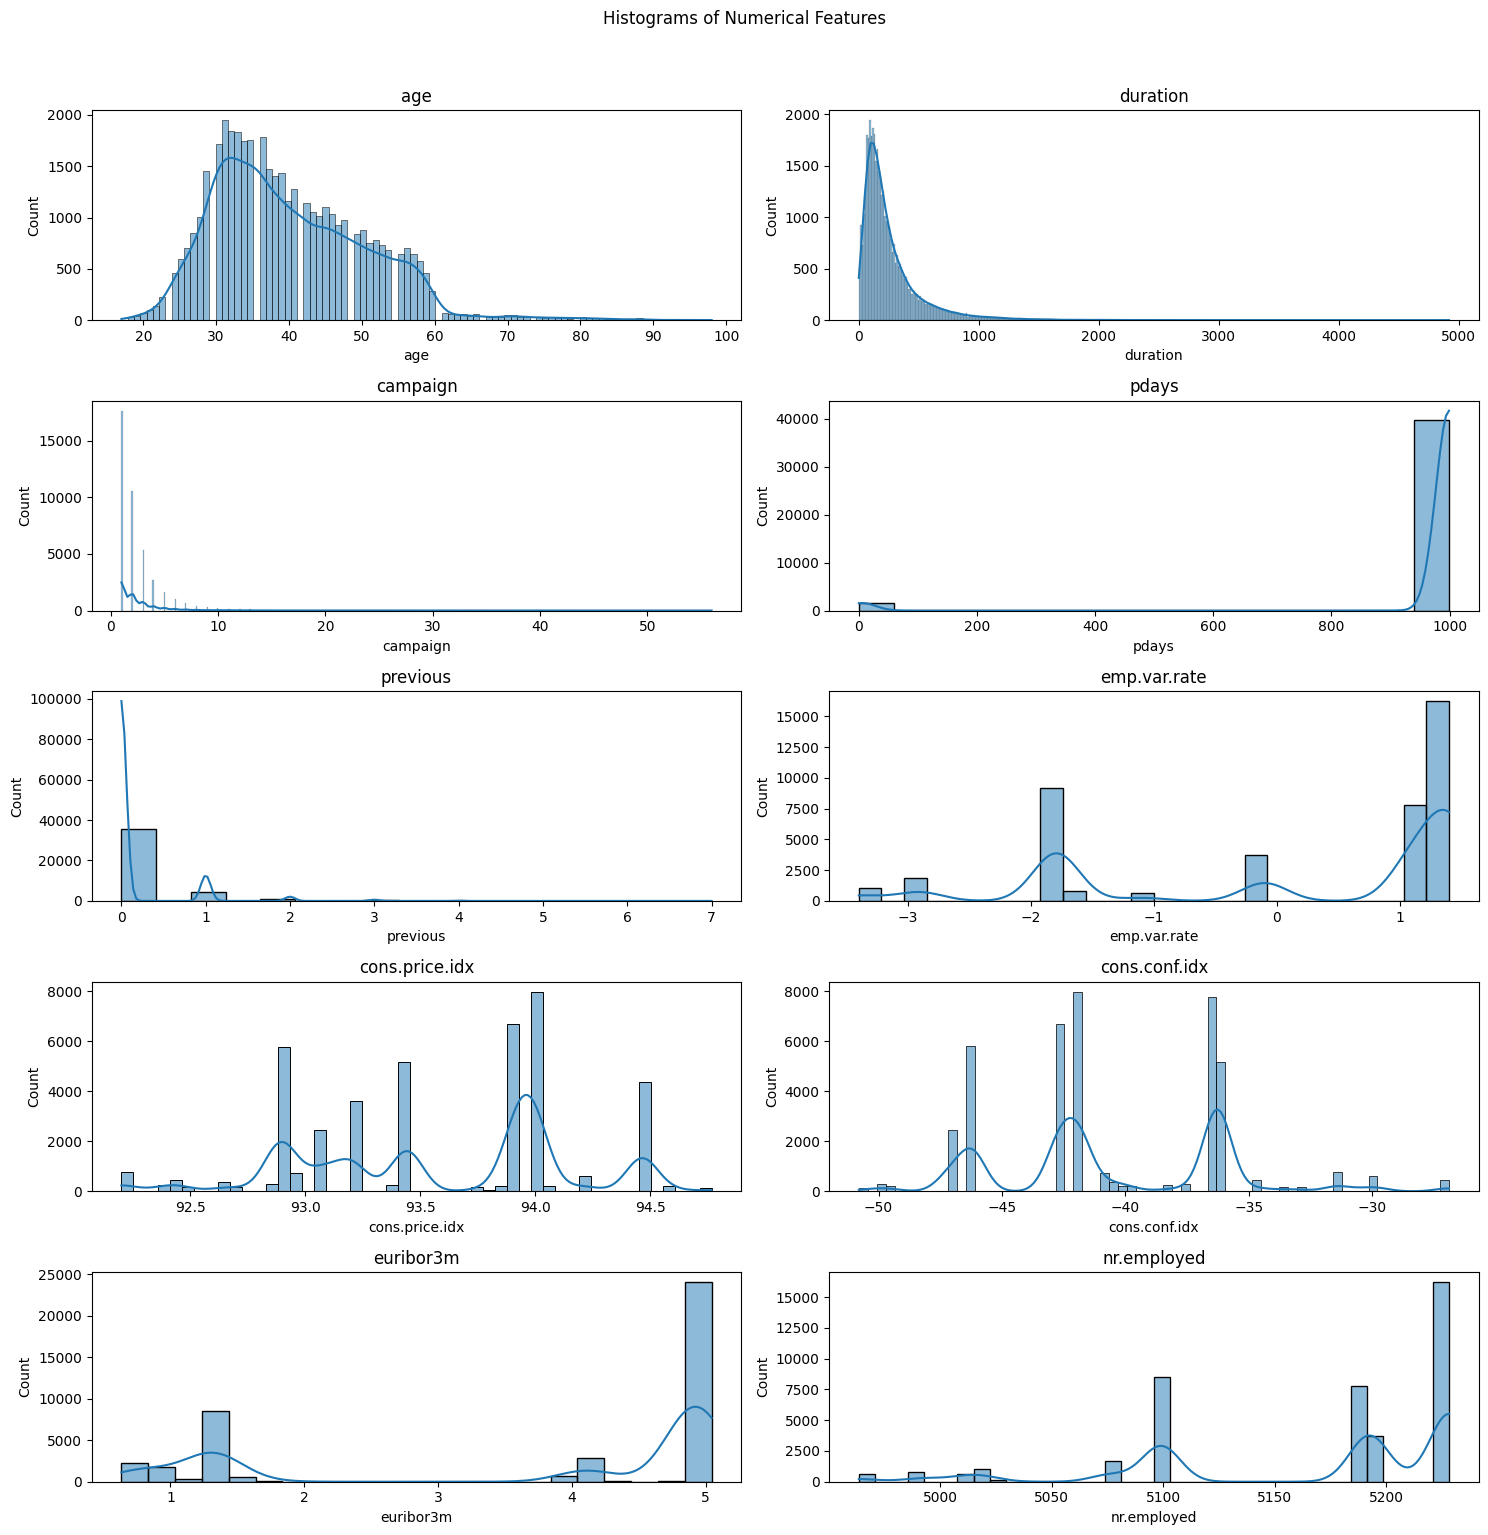

In [5]:
# Visualization for Numerical Features (Histogram)
# Set up subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 15))
fig.suptitle('Histograms of Numerical Features', y=1.02)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot histograms for each numerical feature
for i, column in enumerate(numerical_features.select_dtypes(include='number').columns):
    sns.histplot(numerical_features[column], ax=axes[i], kde=True)
    axes[i].set_title(column)

# Adjust layout
plt.tight_layout()
plt.show()

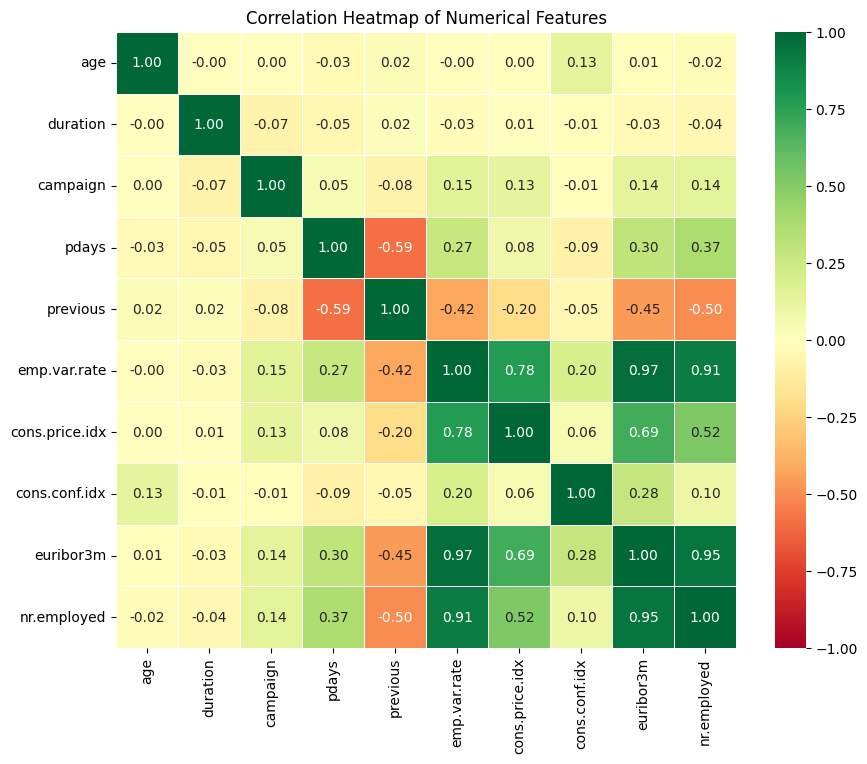

In [6]:
# Visualization for Numerical Features (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_features.corr(), vmin=-1, vmax=1, annot=True, cmap=plt.cm.RdYlGn, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

<Figure size 1200x800 with 0 Axes>

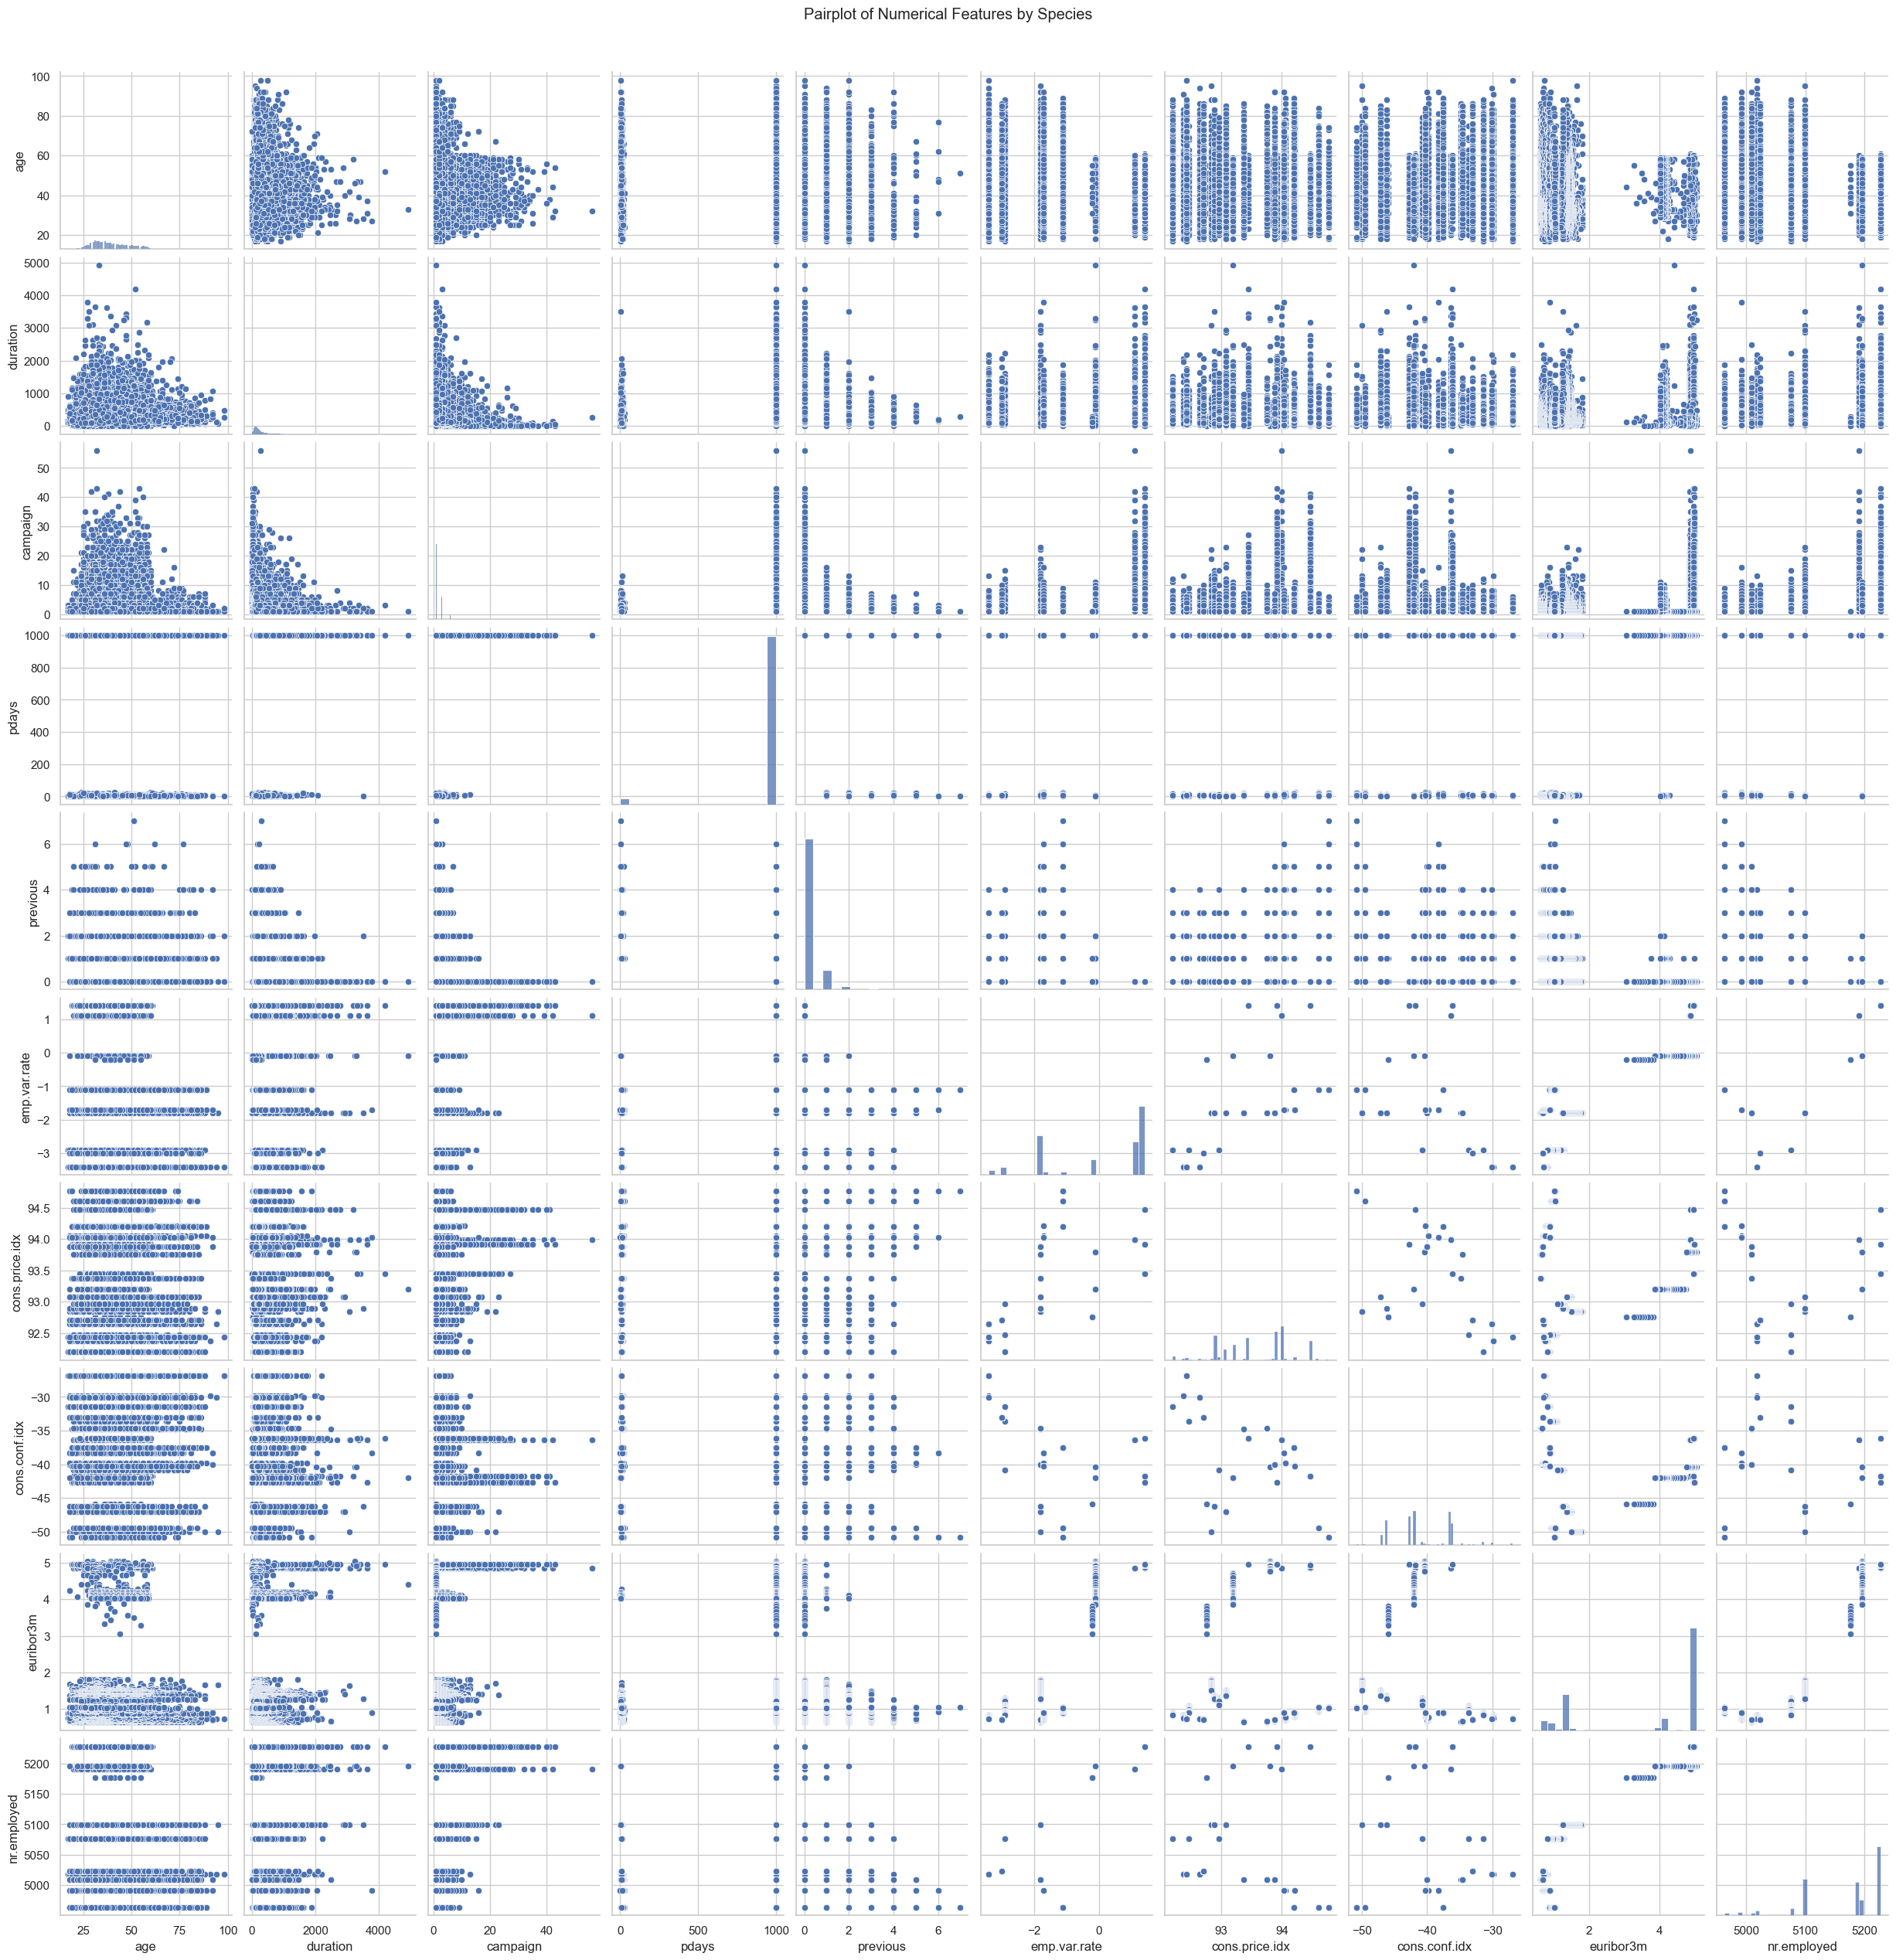

In [7]:
# Visualization for Numerical Features (Pairplot)
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
sns.pairplot(numerical_features, height=2.5, )
plt.suptitle('Pairplot of Numerical Features by Species', y=1.02)
plt.show()

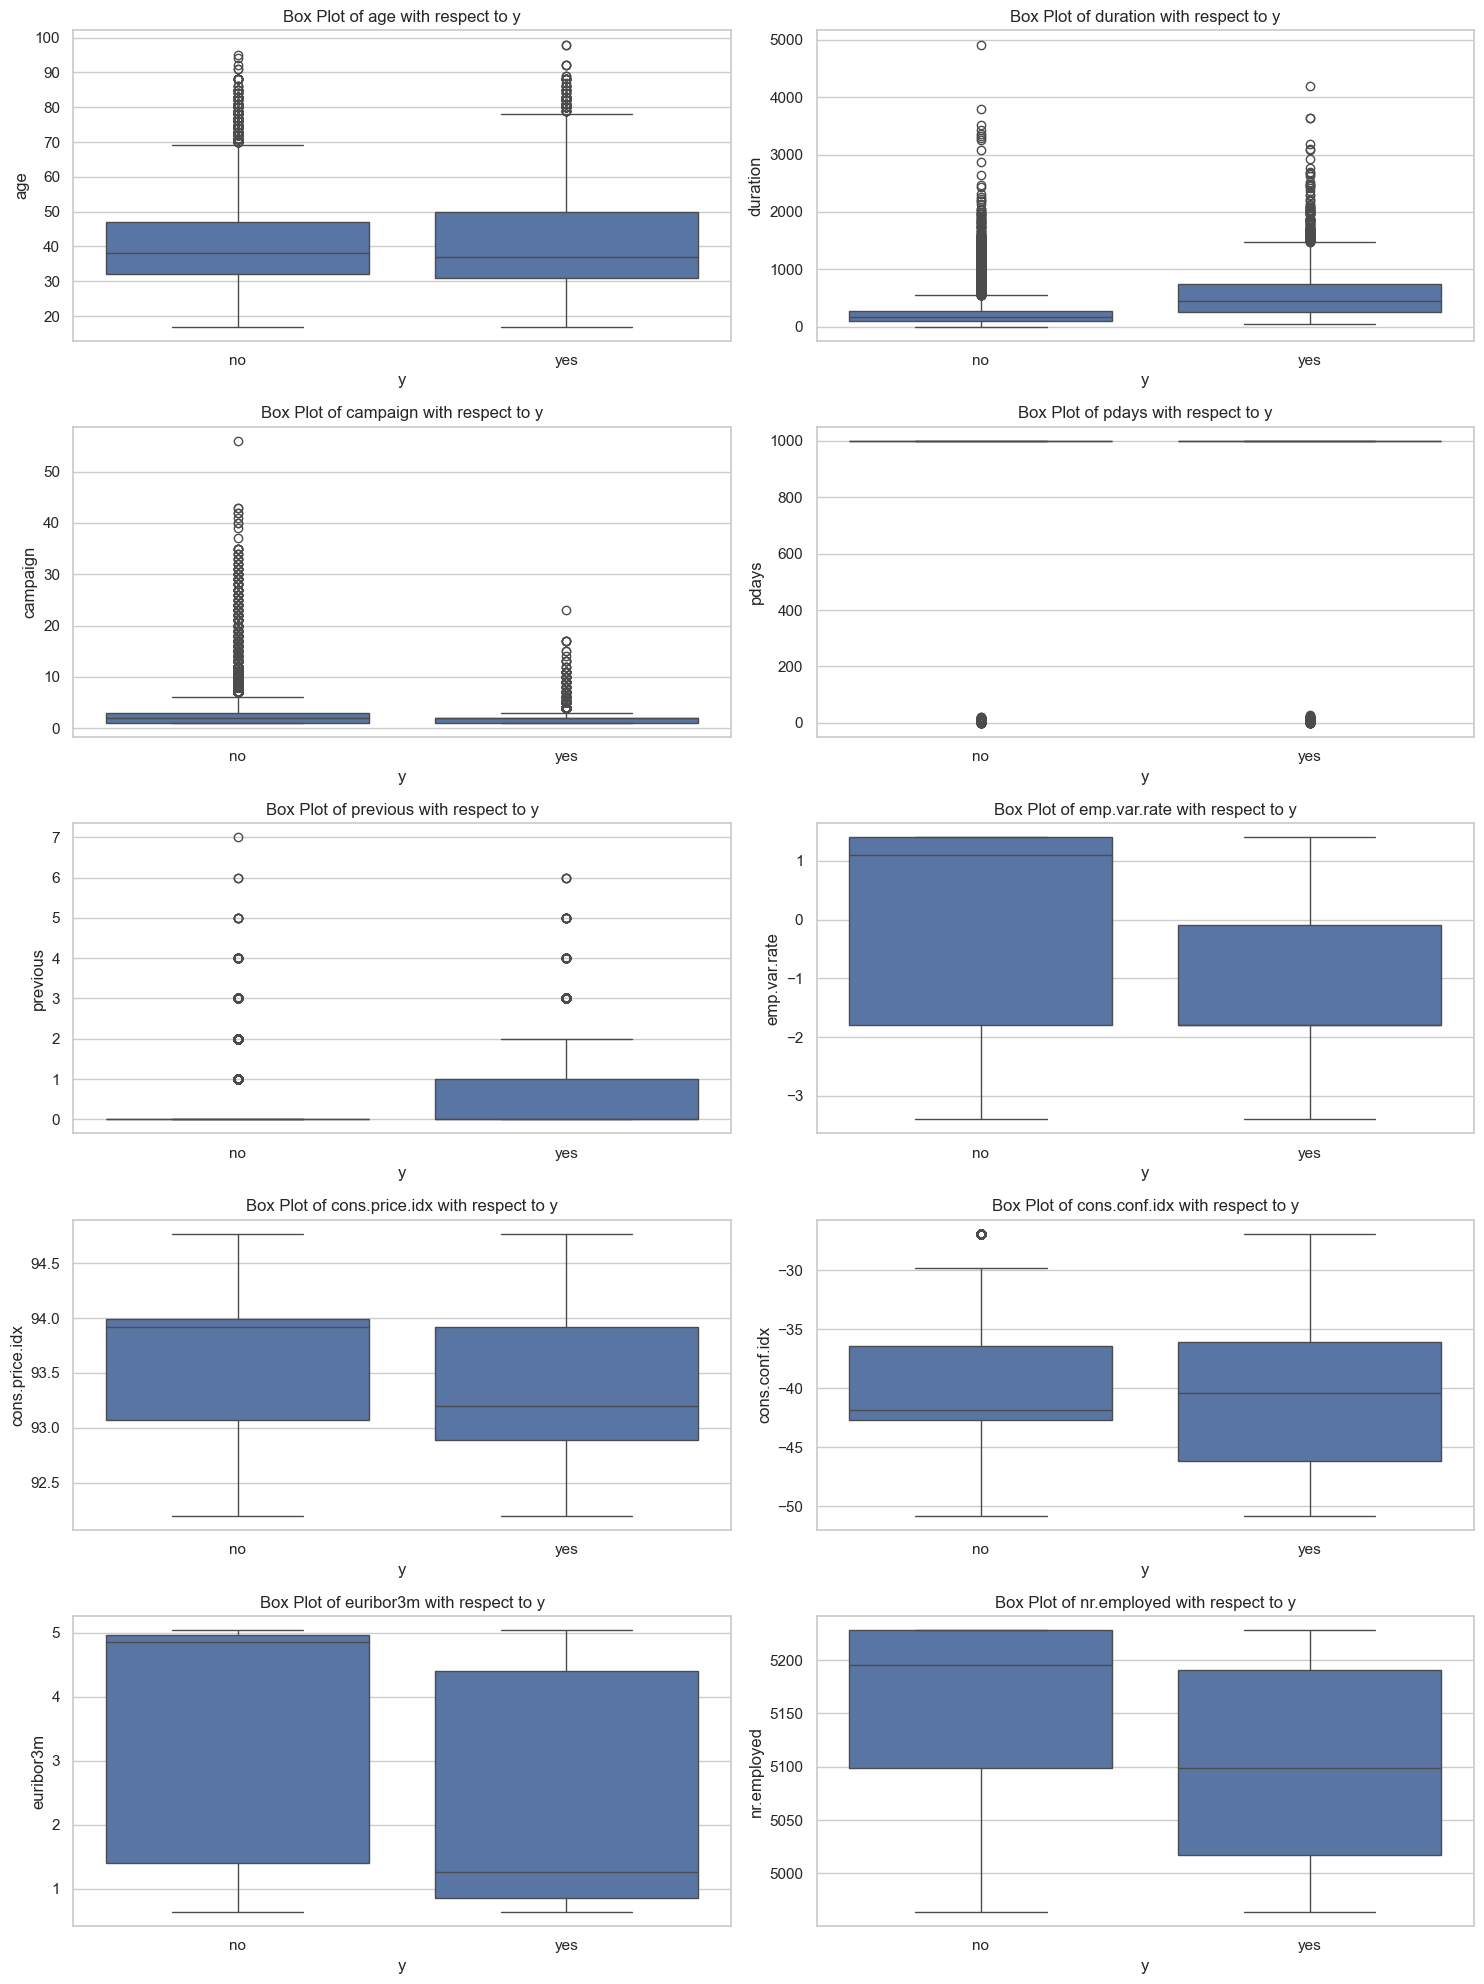

Cleaned Numerical Data:


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


In [8]:
# Plot box plots for every numerical feature with respect to column 'y' in a 5x2 grid
plt.figure(figsize=(15, 20))

for i, column in enumerate(numerical_features.columns, 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x='y', y=numerical_features[column], data=bank_data)
    plt.title(f'Box Plot of {column} with respect to y')

plt.tight_layout()
plt.show()

# Identify and remove outliers using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(numerical_features)

# Identify and remove outliers
numerical_features_cleaned = numerical_features.loc[outliers != -1]

# Display the cleaned data
print("Cleaned Numerical Data:")
display(numerical_features_cleaned.head())

In [9]:
_ = [display(HTML(f"<strong>Distinct values for '{column}':</strong> Count: {len(categorical_features[column].unique())}, Values: {categorical_features[column].unique()}")) 
        for column in categorical_features.columns]

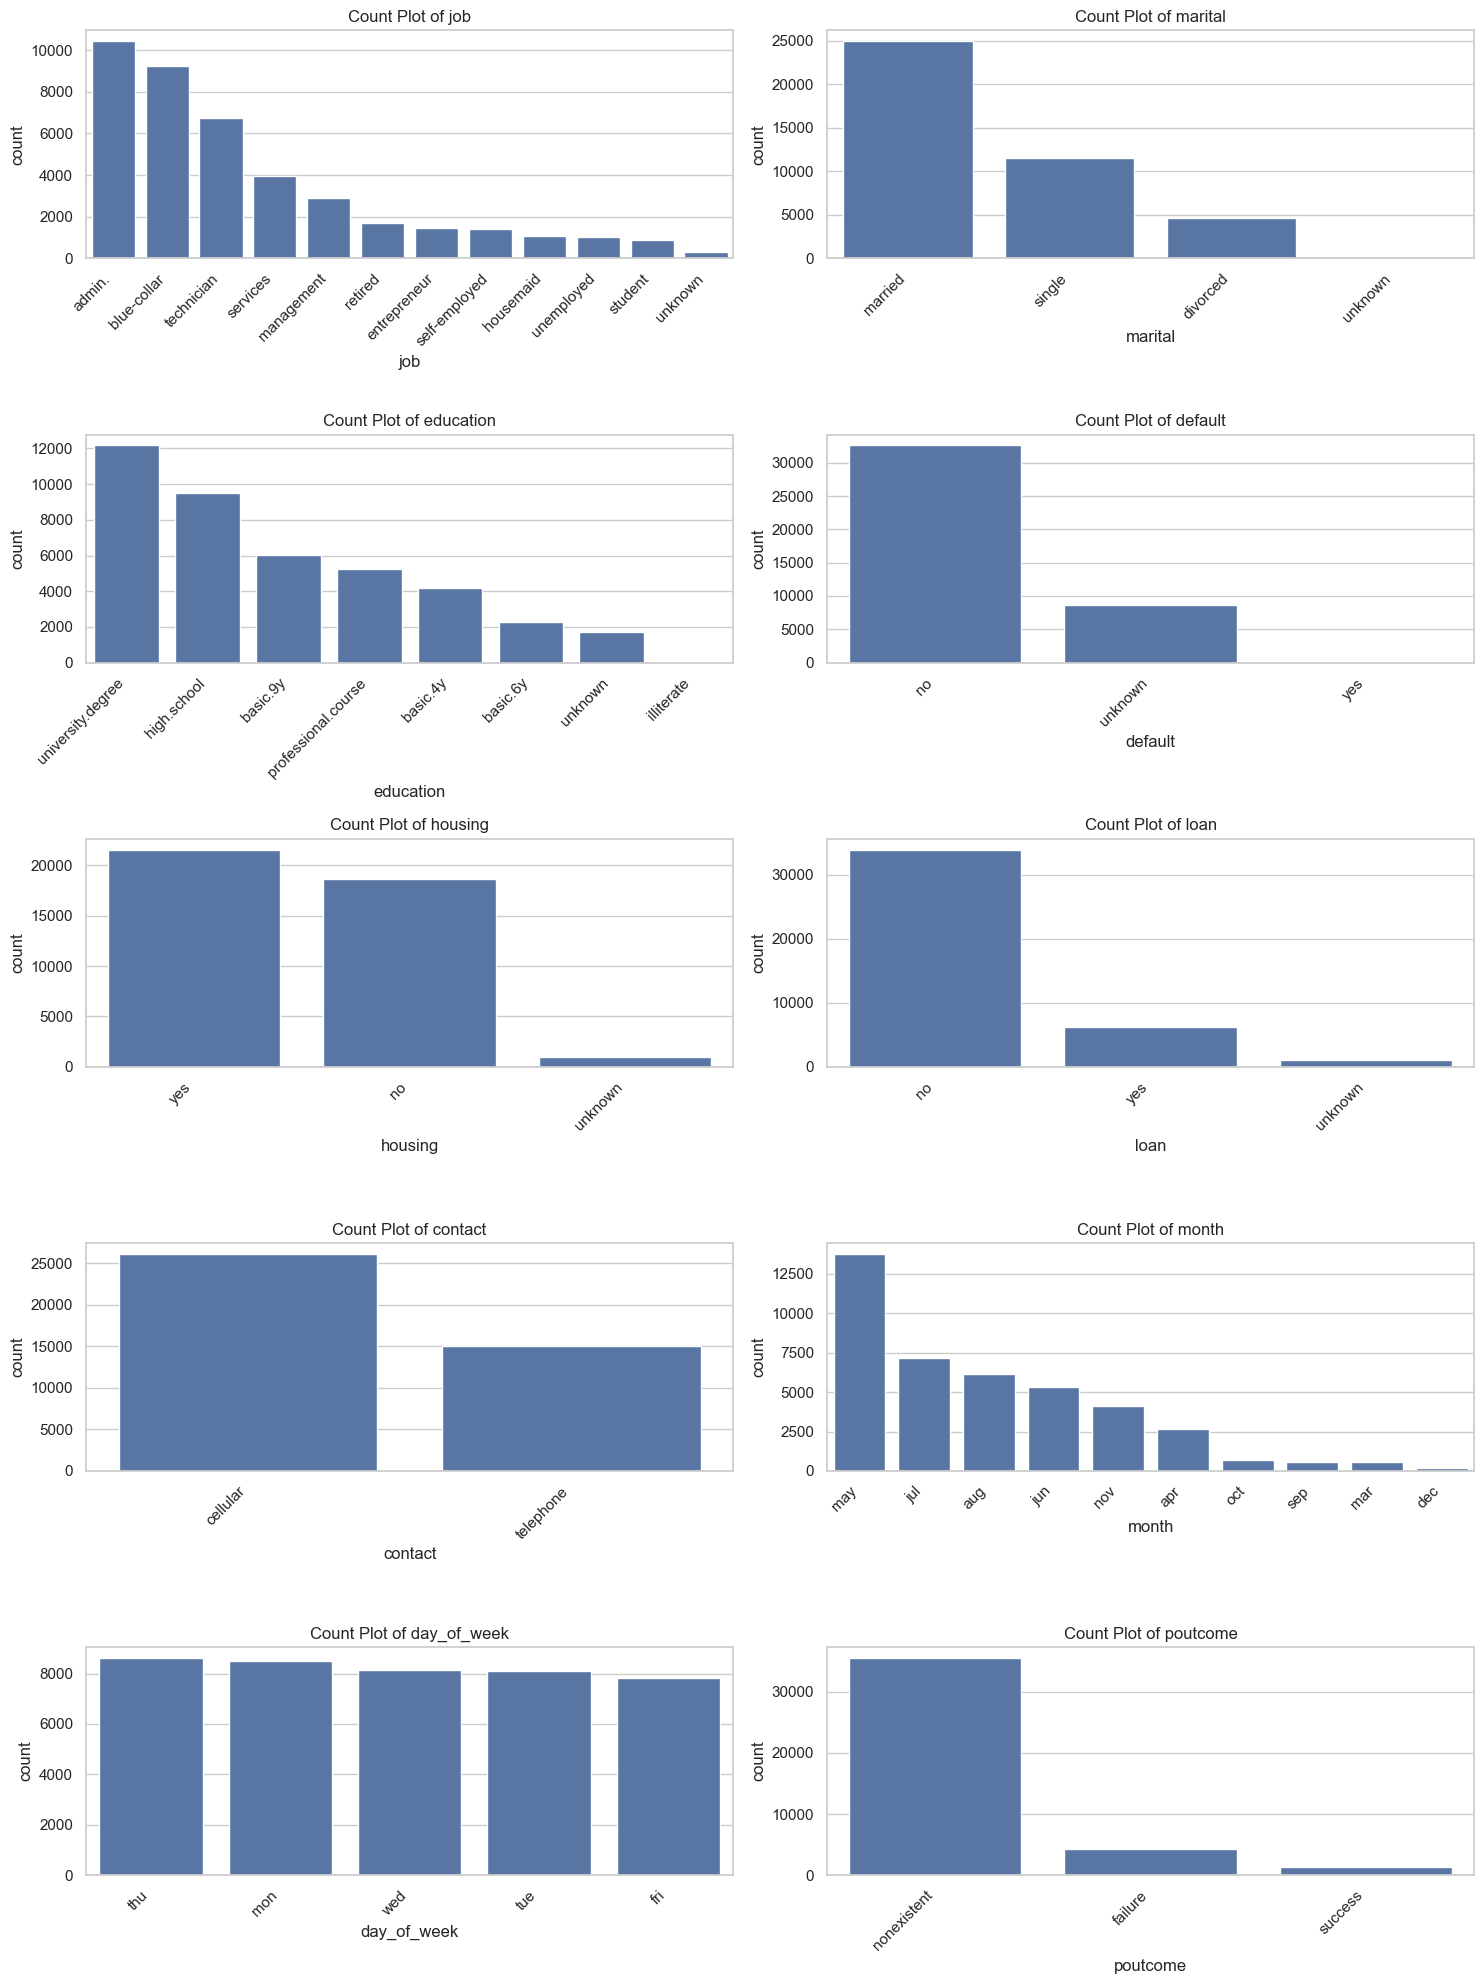

In [10]:
# Visualization for Categorical Features (Count Plot)
# Plot count plots for every categorical feature in a 5x2 grid
plt.figure(figsize=(15, 20))

for i, column in enumerate(categorical_features.columns, 1):
    plt.subplot(5, 2, i)
    sns.countplot(x=column, data=bank_data, order=bank_data[column].value_counts().index)
    plt.title(f'Count Plot of {column}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()

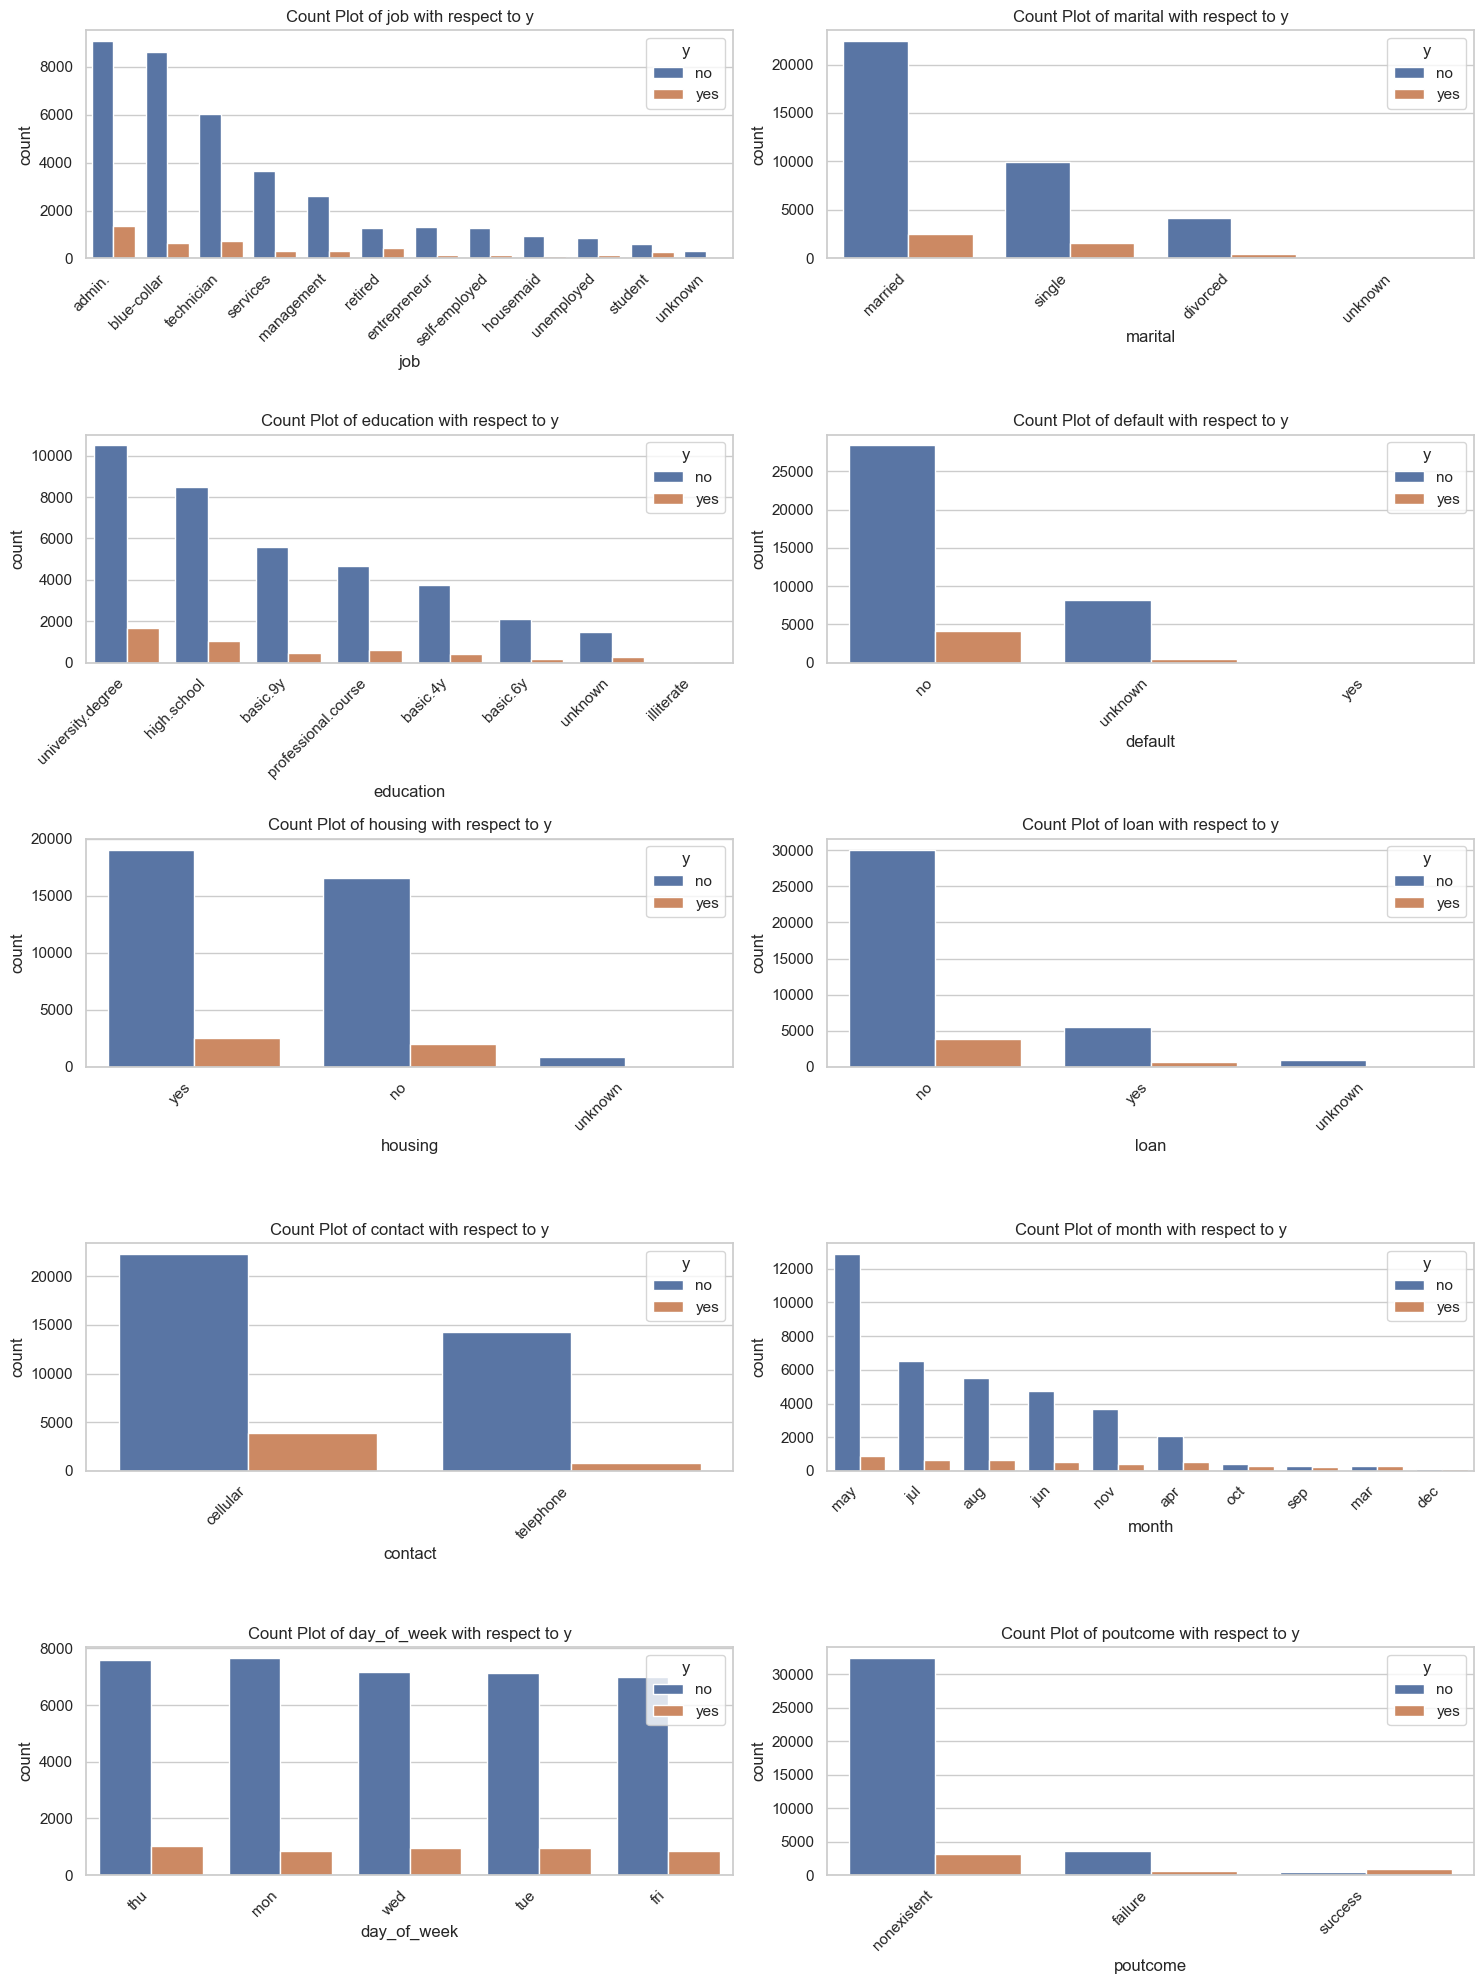

In [11]:
# Plot count plots for every categorical feature in a 5x2 grid with respect to 'y'
plt.figure(figsize=(15, 20))

for i, column in enumerate(categorical_features.columns, 1):
    plt.subplot(5, 2, i)
    sns.countplot(x=column, data=bank_data, hue='y', order=bank_data[column].value_counts().index)
    plt.title(f'Count Plot of {column} with respect to y')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.legend(title='y')

plt.tight_layout()
plt.show()

In [12]:
# Dropping Duration Column as it cannot be used for modelling
bank_data = bank_data.drop(["duration"], axis = 1)

In [13]:
# One-hot encoding for features with a small number of distinct values
one_hot_encoder = OneHotEncoder(drop='first', sparse=False)
one_hot_encoded = pd.DataFrame(one_hot_encoder.fit_transform(categorical_features), columns=one_hot_encoder.get_feature_names_out(categorical_features.columns))

# Label encoding for 'month' feature with a larger number of distinct values
label_encoder = LabelEncoder()
bank_data['month_encoded'] = label_encoder.fit_transform(bank_data['month'])
bank_data['y_encoded'] = label_encoder.fit_transform(bank_data['y'])

# Concatenate the encoded features with the original DataFrame
bank_data_encoded = pd.concat([bank_data, one_hot_encoded], axis=1)

# Drop the original categorical columns and 'month' since it's already encoded
bank_data_encoded.drop(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y'], axis=1, inplace=True)

# Display the encoded data
display(bank_data_encoded.head())

c:\Users\ashle\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,month_encoded,y_encoded,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,6,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,57,1,999,0,1.1,93.994,-36.4,4.857,5191.0,6,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,37,1,999,0,1.1,93.994,-36.4,4.857,5191.0,6,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,40,1,999,0,1.1,93.994,-36.4,4.857,5191.0,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,56,1,999,0,1.1,93.994,-36.4,4.857,5191.0,6,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [14]:
X = bank_data_encoded.drop('y_encoded', axis=1)  # Features
y = bank_data_encoded['y_encoded']  # Target variable

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Choosing a KNN model
best_k = 5  # Replace with the best_k value from your tuning
knn_model = KNeighborsClassifier(n_neighbors=best_k)

# Training the model
knn_model.fit(X_train_scaled, y_train)

# Evaluating the model
y_pred = knn_model.predict(X_test_scaled)

# Generating classification report
classification_rep = classification_report(y_test, y_pred, output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()

display(HTML("<h4>Classification Report:</h4>"))
display(classification_df.style.set_caption("Metrics for each class"))

# Additional display for overall accuracy
accuracy = accuracy_score(y_test, y_pred)
display(HTML(f"<h4>Overall Accuracy:</h4> {accuracy:.2%}"))

# Displaying the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
display(HTML("<h4>Confusion Matrix:</h4>"))
display(conf_matrix_df)

,precision,recall,f1-score,support
0,0.913459,0.968369,0.940113,7303.000000
1,0.534274,0.283422,0.370370,935.000000
accuracy,0.890629,0.890629,0.890629,0.890629
macro avg,0.723867,0.625896,0.655242,8238.000000
weighted avg,0.870422,0.890629,0.875448,8238.000000


,Predicted 0,Predicted 1
Actual 0,7072,231
Actual 1,670,265


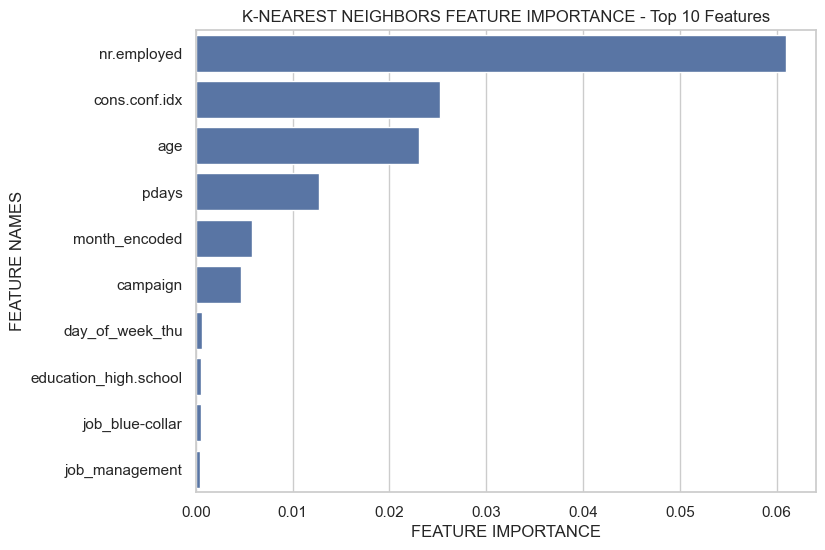

In [15]:
def calculate_permutation_importance(model, X, y, metric=accuracy_score, random_state=None):
    """
    Calculate permutation feature importance for a given model.

    Parameters:
    - model: The machine learning model (e.g., KNeighborsClassifier) for which to calculate feature importance.
    - X: The feature matrix.
    - y: The target variable.
    - metric: The evaluation metric used to assess model performance. Default is accuracy_score.
    - random_state: Random seed for reproducibility.

    Returns:
    - importance: Array containing permutation importance scores for each feature.
    """
    # Clone the model to avoid modifying the original
    model = clone(model)

    # Train the model on the original data
    model.fit(X, y)
    baseline_metric = metric(y, model.predict(X))

    # Initialize an array to store permutation importance scores
    importance = []

    # Random seed for reproducibility
    np.random.seed(random_state)

    # Iterate through each feature and permute its values
    for col in X.columns:
        X_permuted = X.copy()
        X_permuted[col] = np.random.permutation(X_permuted[col])

        # Calculate the metric on the permuted data
        permuted_metric = metric(y, model.predict(X_permuted))

        # Record the change in metric as the importance score for the feature
        importance.append(baseline_metric - permuted_metric)

    return np.array(importance)

def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    top_n = 10
    top_fi_df = fi_df[:top_n]

    # Define size of bar plot
    plt.figure(figsize=(8, 6))

    # Plot Seaborn bar chart
    sns.barplot(x=top_fi_df['feature_importance'], y=top_fi_df['feature_names'])

    # Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE - Top ' + str(top_n) + ' Features')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

# Assuming KNN and X are defined elsewhere in your code
importance_knn = calculate_permutation_importance(KNeighborsClassifier(n_neighbors=5), X, y)
plot_feature_importance(importance_knn, X.columns, 'K-NEAREST NEIGHBORS')

In [16]:
# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Perform grid search
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Display the best parameters and corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

display(pd.DataFrame({'Best Parameters': [best_params], 'Best Accuracy': [best_accuracy]}))

# Evaluate the model with the best parameters on the test set
best_knn_model = grid_search.best_estimator_
y_pred = best_knn_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

display(pd.DataFrame({'Test Accuracy': [test_accuracy]}))

,Best Parameters,Best Accuracy
0,"{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}",0.893718


,Test Accuracy
0,0.8899


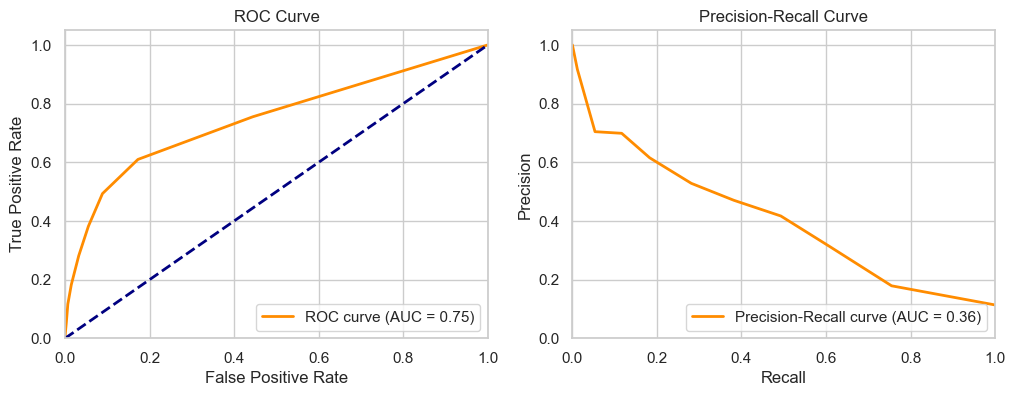

In [17]:
# Predict probabilities for the positive class
y_prob = best_knn_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall curve and area under the curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

# Plot ROC curve and Precision-Recall curve
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot ROC curve
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")

# Plot Precision-Recall curve
axes[1].plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve (AUC = {:.2f})'.format(pr_auc))
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="lower right")

plt.show()

In [18]:
# finds the nearest neighbors for a specific test instance and displays the corresponding rows from the training data.

# Find the indices of the nearest neighbors for a specific test instance
test_instance_index = 0  # Replace with the index of the instance you're interested in
test_instance = X_test.iloc[[test_instance_index]]

# Fit a Nearest Neighbors model on the training data
nn_model = NearestNeighbors(n_neighbors=best_knn_model.n_neighbors)
nn_model.fit(X_train)

# Find the indices and distances of the nearest neighbors
distances, indices = nn_model.kneighbors(test_instance)

# Display the nearest neighbors
nearest_neighbors = X_train.iloc[indices[0]]
display(nearest_neighbors)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,month_encoded,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,marital_unknown,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
32879,57,1,999,0,-1.8,92.893,-46.2,1.299,5099.1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
32882,57,1,999,1,-1.8,92.893,-46.2,1.299,5099.1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32873,57,1,999,0,-1.8,92.893,-46.2,1.299,5099.1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
32933,57,1,999,0,-1.8,92.893,-46.2,1.299,5099.1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
32954,58,1,999,1,-1.8,92.893,-46.2,1.299,5099.1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35865,57,1,999,1,-1.8,92.893,-46.2,1.259,5099.1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30520,57,2,999,1,-1.8,92.893,-46.2,1.354,5099.1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
35481,57,1,999,0,-1.8,92.893,-46.2,1.244,5099.1,6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
32336,57,2,999,1,-1.8,92.893,-46.2,1.313,5099.1,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
